# Gather and clean the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ----------------------------------------------------------
# 1. Configure tickers, dates, and data source
# ----------------------------------------------------------

tickers = ["VTI", "AGG", "DBC", "^VIX"]  # ^VIX is the symbol used by Yahoo
start_date = "2006-01-01"
end_date = "2020-04-30"

In [ ]:
# ----------------------------------------------------------
# 2. Download data from Yahoo Finance
# ----------------------------------------------------------

df_raw = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  4 of 4 completed


In [ ]:
# The returned DataFrame has multiple levels of columns: (Adj Close, Open, High, etc.)
# We'll focus on 'Adj Close' for daily close prices (adjusted for splits/dividends).

df_prices = df_raw["Adj Close"].copy()

In [ ]:
# ----------------------------------------------------------
# 3. Handle missing data
# ----------------------------------------------------------
# Forward-fill to handle weekends/holidays or sporadic missing points,
# then drop remaining rows if any remain unfilled

df_prices.ffill(inplace=True)
df_prices.dropna(inplace=True)

In [ ]:
# ----------------------------------------------------------
# 4. Create daily returns
# ----------------------------------------------------------
# Simple percentage returns: (price_t - price_(t-1)) / price_(t-1)

df_returns = df_prices.pct_change().dropna()

In [ ]:
# Rename columns to something consistent (optional)
# VIX is typically just an index level, but we’ll treat it consistently here

df_prices.columns = ['VTI', 'AGG', 'DBC', 'VIX']
df_returns.columns = ['VTI', 'AGG', 'DBC', 'VIX']

In [ ]:
# ----------------------------------------------------------
# 5. (Optional) Quick sanity checks
# ----------------------------------------------------------
# - Check the first few rows

display(df_prices.head())
display(df_returns.head())

,VTI,AGG,DBC,VIX
Date,,,,
2006-02-06,55.403763,19.830791,44.355057,13.04
2006-02-07,55.365047,19.257175,43.923199,13.59
2006-02-08,55.337399,19.175228,44.239182,12.83
2006-02-09,55.370583,19.355509,44.154934,13.12
2006-02-10,55.254536,19.003143,44.246227,12.87


,VTI,AGG,DBC,VIX
Date,,,,
2006-02-07,-0.000699,-0.028926,-0.009736,0.042178
2006-02-08,-0.000499,-0.004255,0.007194,-0.055923
2006-02-09,0.000600,0.009402,-0.001904,0.022603
2006-02-10,-0.002096,-0.018205,0.002068,-0.019055
2006-02-13,0.000700,-0.015524,-0.004523,0.037296


In [ ]:
# - Check the date range
print(f"Price data from {df_prices.index[0]} to {df_prices.index[-1]}")

# - See if any missing values remain
print("Any NA values left?", df_prices.isna().any().any(), df_returns.isna().any().any())

Price data from 2006-02-06 00:00:00 to 2020-04-29 00:00:00
Any NA values left? False False


In [ ]:
# ----------------------------------------------------------
# 6. Final data structures
# ----------------------------------------------------------
# df_prices: Cleaned, daily adjusted close prices for VTI, AGG, DBC, VIX
# df_returns: Corresponding daily returns

# Building input features

In [ ]:
def build_lstm_features(df_prices, df_returns, window=50):
    """
    Build 3D feature arrays for LSTM training, stacking both
    prices and returns for each asset over a specified lookback window.

    :param df_prices: DataFrame of shape (T, n_assets) with daily prices.
    :param df_returns: DataFrame of shape (T, n_assets) with daily returns.
    :param window: Lookback window size (number of past days to include).

    :return: A NumPy array of shape (num_samples, window, 2*n_assets).
             Each row is one sample, containing 'window' days of
             [prices + returns] for all assets.
    """
    # 1) Combine prices and returns into a single DataFrame
    #    We'll create multi-level columns: ("price", asset), ("return", asset).
    df_combined = pd.concat(
        {
            "price": df_prices,
            "return": df_returns
        },
        axis=1
    ).dropna()

    # 2) Convert to NumPy for slicing
    data = df_combined.values  # shape: (T, 2*n_assets)

    num_samples = data.shape[0]
    n_features = data.shape[1]  # Should be 2 * number_of_assets

    # 3) Create 3D array: (num_sequences, window, n_features)
    X_list = []
    for i in range(window, num_samples):
        # Slice rows [i-window, i) for all columns
        X_window = data[i-window:i, :]
        X_list.append(X_window)

    X_array = np.array(X_list)  # shape => (num_samples - window, window, 2*n_assets)

    return X_array

In [ ]:
# -------------------------------------------------------------------
# Example usage
# -------------------------------------------------------------------

# Suppose you have df_prices & df_returns from the data-cleaning snippet
WINDOW_SIZE = 50
X_data = build_lstm_features(df_prices, df_returns, window=WINDOW_SIZE)

print("Shape of X_data:", X_data.shape)

Shape of X_data: (3531, 50, 8)


# Scaling and splitting the data

In [ ]:
# ----------------------------------------------------------
# 1. Standardize returns (mean = 0, std = 1)
# ----------------------------------------------------------

scaler_returns = StandardScaler()
df_returns_scaled = pd.DataFrame(
    scaler_returns.fit_transform(df_returns),
    index=df_returns.index,
    columns=df_returns.columns
)

In [ ]:
# ----------------------------------------------------------
# 2. Normalize prices (optional, but usually not needed)
# ----------------------------------------------------------

scaler_prices = StandardScaler()
df_prices_scaled = pd.DataFrame(
    scaler_prices.fit_transform(df_prices),
    index=df_prices.index,
    columns=df_prices.columns
)

In [ ]:
def two_year_train_test_split(df_returns, train_years=1, test_years=1):
    """
    Splits data into train-test sets using a 2-year rolling training window.

    :param df_returns: Scaled returns DataFrame
    :param train_years: Length of training period in years
    :param test_years: Length of testing period in years
    :return: List of (train, test) tuples
    """
    days_per_year = 252  # Approximate number of trading days per year
    train_days = train_years * days_per_year
    test_days = test_years * days_per_year

    num_samples = len(df_returns)
    split_indices = []

    for train_end in range(train_days, num_samples, test_days):
        train_start = 0  # Always train from the beginning
        test_start = train_end
        test_end = test_start + test_days

        if test_end > num_samples:
            break  # Avoid incomplete last test set

        train_data = df_returns.iloc[train_start:test_start]
        test_data = df_returns.iloc[test_start:test_end]
        split_indices.append((train_data, test_data))

    return split_indices

In [ ]:
# Example usage:
two_year_splits = two_year_train_test_split(df_returns_scaled)

# Check first split
print("Train period:", two_year_splits[12][0].index[0], "to", two_year_splits[12][0].index[-1])
print("Test period:", two_year_splits[12][1].index[0], "to", two_year_splits[12][1].index[-1])

Train period: 2006-02-07 00:00:00 to 2019-02-12 00:00:00
Test period: 2019-02-13 00:00:00 to 2020-02-12 00:00:00


# Define the deep learning model architecture.

In [ ]:
# Define model parameters
WINDOW_SIZE = 50  # Lookback period for LSTM
NUM_ASSETS = 4  # VTI, AGG, DBC, VIX
FEATURES_PER_ASSET = 2  # Using both prices and returns
INPUT_SHAPE = (WINDOW_SIZE, NUM_ASSETS * FEATURES_PER_ASSET)

In [ ]:
# ----------------------------------------------------------
# Define the LSTM Model
# ----------------------------------------------------------

def build_lstm_model():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE),  # First LSTM layer
        Dropout(0.3),  # Prevent overfitting
        LSTM(32, return_sequences=False),  # Second LSTM layer
        Dense(NUM_ASSETS, activation="softmax", kernel_regularizer=l2(0.001))  # Output layer (Portfolio weights)
    ])

    return model

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
# ----------------------------------------------------------
# Instantiate and display the model
# ----------------------------------------------------------

lstm_model = build_lstm_model()
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,236 (122.02 KB)

 Trainable params: 31,236 (122.02 KB)

 Non-trainable params: 0 (0.00 B)

# Implementing the sharpe ratio objective function

In [ ]:
def sharpe_ratio_loss(y_true, y_pred):
    """
    Custom loss function that calculates the negative Sharpe ratio.

    :param y_true: True asset returns (batch_size, num_assets)
    :param y_pred: Predicted portfolio weights (batch_size, num_assets)
    :return: Negative Sharpe ratio (to minimize)
    """
    # Compute portfolio returns (batch_size, 1) = Sum of (weights * actual returns)
    portfolio_returns = K.sum(y_pred * y_true, axis=1, keepdims=True)  # Ensure shape (batch_size, 1)

    # Compute mean return (E[Rp]) over batch
    mean_return = K.mean(portfolio_returns, axis=0)  # Ensure scalar output

    # Compute standard deviation of portfolio returns (Std[Rp])
    std_return = K.sqrt(K.var(portfolio_returns, axis=0) + K.epsilon())  # Ensure scalar output

    # Compute Sharpe ratio (mean return / std deviation)
    sharpe_ratio = mean_return / (std_return + K.epsilon())  # Add epsilon to avoid division by zero

    # Return NEGATIVE Sharpe ratio (so we can minimize)
    return -sharpe_ratio  # Ensure it's a scalar loss


# Train the Model Using Gradient Ascent

In [ ]:
# ----------------------------------------------------------
# 1. Compile the Model with the Sharpe Ratio Loss
# ----------------------------------------------------------

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=sharpe_ratio_loss)

In [ ]:
# ----------------------------------------------------------
# 2. Prepare Training Data (Rolling Window)
# ----------------------------------------------------------

def prepare_batches(train_data_prices, train_data_returns, window_size=50):
    """
    Converts returns and prices into rolling window batches for LSTM training.

    :param train_data_prices: Prices DataFrame (T, num_assets).
    :param train_data_returns: Returns DataFrame (T, num_assets).
    :param window_size: Number of past days used for each prediction.
    :return: Tuple (X, y), where X has shape (samples, window, num_features)
             and y has shape (samples, num_assets).
    """
    X_list, y_list = [], []
    num_assets = train_data_prices.shape[1]

    for i in range(window_size, len(train_data_prices)):
        X_window_prices = train_data_prices.iloc[i-window_size:i].values
        X_window_returns = train_data_returns.iloc[i-window_size:i].values

        X_window = np.hstack([X_window_prices, X_window_returns])  # Concatenate features
        y_target = train_data_returns.iloc[i].values  # Next-day returns

        X_list.append(X_window)
        y_list.append(y_target)

    return np.array(X_list), np.array(y_list)

In [ ]:
def reset_model():
    K.clear_session()  # Clears any existing model state
    return build_lstm_model()  # Rebuilds a fresh LSTM model

In [ ]:
import numpy as np
import pandas as pd

def compute_performance_metrics(portfolio_returns, risk_free_rate=0.0):
    """
    Compute various performance metrics for a portfolio return series.

    :param portfolio_returns: NumPy array or Pandas Series of daily portfolio returns.
    :param risk_free_rate: Annual risk-free rate (default: 0.0).
    :return: Dictionary containing calculated performance metrics.
    """
    if isinstance(portfolio_returns, pd.Series):
        portfolio_returns = portfolio_returns.values

    if portfolio_returns.size == 0:
        # Return default values if no returns are provided
        return {
            "Annualized Return": 0.0,
            "Annualized Volatility": 0.0,
            "Sharpe Ratio": 0.0,
            "Downside Deviation": 0.0,
            "Sortino Ratio": 0.0,
            "Max Drawdown": 0.0,
            "Percent Positive Returns": 0.0,
            "Profit Loss Ratio": 0.0,
            # "Cumulative Returns": np.array([1.0]) # Optional: if needed later
        }

    trading_days_per_year = 252

    # 1. Annualized Return (Geometric mean can also be used)
    mean_daily_return = np.mean(portfolio_returns)
    annualized_return = mean_daily_return * trading_days_per_year
    # Alternative: Geometric Mean
    # annualized_return = (np.prod(1 + portfolio_returns)**(trading_days_per_year / len(portfolio_returns))) - 1


    # 2. Annualized Volatility (Standard Deviation)
    volatility = np.std(portfolio_returns) * np.sqrt(trading_days_per_year)

    # 3. Sharpe Ratio
    # Add epsilon to denominator to prevent division by zero
    sharpe_ratio = (annualized_return - risk_free_rate) / (volatility + 1e-8)

    # 4. Downside Deviation
    negative_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.std(negative_returns) * np.sqrt(trading_days_per_year) if len(negative_returns) > 0 else 0.0

    # 5. Sortino Ratio
    # Add epsilon to denominator
    sortino_ratio = (annualized_return - risk_free_rate) / (downside_deviation + 1e-8) if downside_deviation > 1e-8 else 0.0

    # 6. Cumulative Returns and Max Drawdown
    cumulative_returns_arr = np.cumprod(1 + portfolio_returns)
    peak = np.maximum.accumulate(cumulative_returns_arr)
    drawdown = (cumulative_returns_arr - peak) / (peak + 1e-8) # Add epsilon to peak
    max_drawdown = np.min(drawdown) if len(drawdown) > 0 else 0.0

    # 7. Percentage of Positive Returns
    percent_positive = (np.sum(portfolio_returns > 0) / len(portfolio_returns)) * 100 if len(portfolio_returns) > 0 else 0.0

    # 8. Average Profit / Average Loss Ratio
    positive_returns = portfolio_returns[portfolio_returns > 0]
    negative_returns = portfolio_returns[portfolio_returns < 0]
    avg_profit = np.mean(positive_returns) if len(positive_returns) > 0 else 0.0
    avg_loss = np.mean(negative_returns) if len(negative_returns) > 0 else 0.0 # Avg loss is negative
    profit_loss_ratio = abs(avg_profit / (avg_loss + 1e-8)) if avg_loss < -1e-8 else 0.0 # Add epsilon

    return {
        "Annualized Return": annualized_return,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Percent Positive Returns": percent_positive,
        "Profit Loss Ratio": profit_loss_ratio,
        # "Cumulative Returns": cumulative_returns_arr # Optional: if needed later
    }

In [ ]:
def fixed_allocation_strategy(df_returns, allocation_weights):
    """
    Implements a fixed allocation strategy and computes portfolio returns.

    :param df_returns: DataFrame of daily asset returns (T, num_assets)
    :param allocation_weights: List of fixed portfolio weights (num_assets)
    :return: Series of portfolio returns
    """
    allocation_weights = np.array(allocation_weights)  # Ensure NumPy array
    assert len(allocation_weights) == df_returns.shape[1], "Weights must match asset count"

    # Compute portfolio returns (fixed weights * asset returns)
    portfolio_returns = df_returns @ allocation_weights  # Matrix multiplication

    return portfolio_returns


In [ ]:
# Define fixed allocation strategies
allocations = {
    "Allocation 1": [0.25, 0.25, 0.25, 0.25],  # Equal allocation
    "Allocation 2": [0.50, 0.10, 0.20, 0.20],  # Stock-heavy
    "Allocation 3": [0.10, 0.50, 0.20, 0.20],  # Bond-heavy
    "Allocation 4": [0.40, 0.40, 0.10, 0.10],  # Balanced stocks & bonds
}

In [ ]:
import cvxpy as cp

def mean_variance_optimization(df_returns, window=50, risk_aversion=1):
    """
    Implements Markowitz Mean-Variance Optimization (MVO) to find optimal portfolio weights.

    :param df_returns: DataFrame of daily asset returns (T, num_assets)
    :param window: Lookback window for estimating returns & covariance matrix
    :param risk_aversion: Risk tolerance factor (higher = more conservative)
    :return: Portfolio returns using MVO strategy
    """
    num_assets = df_returns.shape[1]
    portfolio_returns = []

    for t in range(window, len(df_returns)):
        # 1️⃣ Estimate expected returns & covariance matrix
        historical_returns = df_returns.iloc[t - window:t]  # Lookback window
        mean_returns = historical_returns.mean().values  # Expected returns
        cov_matrix = historical_returns.cov().values  # Covariance matrix

        # 2️⃣ Solve for optimal weights using convex optimization
        w = cp.Variable(num_assets)  # Portfolio weights
        objective = cp.Maximize(mean_returns @ w - risk_aversion * cp.quad_form(w, cov_matrix))
        constraints = [cp.sum(w) == 1, w >= 0]  # Long-only portfolio

        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS)  # Works for most convex problems

        # Ensure valid weights (fallback to equal-weight if infeasible)
        if w.value is None:
            weights = np.ones(num_assets) / num_assets
        else:
            weights = w.value

        # 3️⃣ Compute portfolio return for this period
        portfolio_return = np.sum(weights * df_returns.iloc[t].values)
        portfolio_returns.append(portfolio_return)

    return np.array(portfolio_returns)  # Return time-series of portfolio returns


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def maximum_diversification_optimization(df_returns, window=50):
    """
    Implements Maximum Diversification (MD) Optimization.

    Maximizes the diversification ratio: (w^T * σ) / sqrt(w^T * Σ * w)
    Where w = weights, σ = asset volatilities, Σ = covariance matrix.

    :param df_returns: DataFrame of daily asset returns (T, num_assets)
    :param window: Lookback window for estimating covariance matrix & volatilities
    :return: Portfolio returns using MD strategy
    """
    num_assets = df_returns.shape[1]
    portfolio_returns = []
    last_weights = np.ones(num_assets) / num_assets # Start with equal weights

    for t in range(window, len(df_returns)):
        # 1️⃣ Estimate covariance matrix and asset volatilities
        historical_returns = df_returns.iloc[t - window:t]
        cov_matrix = historical_returns.cov().values
        asset_vols = historical_returns.std().values

        # Ensure volatilities are not zero to avoid division issues
        asset_vols = np.maximum(asset_vols, 1e-6) # Add small epsilon

        # 2️⃣ Define the objective function (negative diversification ratio)
        def objective(w):
            portfolio_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
            weighted_avg_vol = np.dot(w, asset_vols)
            # Add epsilon to denominator to prevent division by zero
            diversification_ratio = weighted_avg_vol / (portfolio_vol + 1e-8)
            return -diversification_ratio # Minimize negative ratio

        # 3️⃣ Define constraints and bounds
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) # Sum of weights = 1
        bounds = tuple((0, 1) for _ in range(num_assets)) # Weights between 0 and 1

        # 4️⃣ Solve for optimal weights
        # Use previous weights as initial guess for stability
        opt_result = minimize(objective, last_weights, method='SLSQP',
                              bounds=bounds, constraints=constraints)

        # Ensure valid weights (fallback to equal-weight if optimization fails)
        if not opt_result.success or np.any(np.isnan(opt_result.x)):
            weights = np.ones(num_assets) / num_assets
            # print(f"MD Optimization failed at step {t}, using equal weights.") # Optional warning
        else:
            weights = opt_result.x
            # Normalize weights again due to potential floating point inaccuracies
            weights /= np.sum(weights)

        last_weights = weights # Store for next iteration's guess

        # 5️⃣ Compute portfolio return for this period
        portfolio_return = np.sum(weights * df_returns.iloc[t].values)
        portfolio_returns.append(portfolio_return)

    return np.array(portfolio_returns)

In [ ]:
import random
import numpy as np

# For reproducibility
SEED = 42

# Python built-in random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch (if using)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TensorFlow (if using)
import tensorflow as tf
tf.random.set_seed(SEED)


In [ ]:
# # Before the loop
# results_summary = []
# test_periods = [] # To store start/end dates

all_results_summary = {}

for i in range(0, 13):

    # ----------------------------------------------------------
    # Reset and Train LSTM Model
    # ----------------------------------------------------------

    lstm_model = reset_model()

    # Prepare dataset
    train_prices = two_year_splits[i][0]  # Use first train period for prices
    train_returns = df_returns_scaled.loc[train_prices.index]  # Ensure matching index
    X_train, y_train = prepare_batches(train_prices, train_returns, window_size=50)

    # Compile & train LSTM model
    lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss=sharpe_ratio_loss)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Prepare test data
    test_prices = two_year_splits[i][1]
    test_returns = df_returns_scaled.loc[test_prices.index]
    X_test, y_test = prepare_batches(test_prices, test_returns, window_size=50)

    # ----------------------------------------------------------
    # LSTM Model Predictions
    # ----------------------------------------------------------

    predicted_weights = lstm_model.predict(X_test, verbose=0)

    # --- Evaluate LSTM ---
    portfolio_returns_lstm = np.sum(predicted_weights * y_test, axis=1)
    metrics_lstm = compute_performance_metrics(portfolio_returns_lstm)

    # --- Evaluate Fixed Allocations ---
    metrics_allocations = {}
    for name, weights in allocations.items():
        portfolio_returns_alloc = fixed_allocation_strategy(test_returns, weights)
        metrics_allocations[name] = compute_performance_metrics(portfolio_returns_alloc)

    # --- Evaluate MVO ---
    portfolio_returns_mvo = mean_variance_optimization(test_returns, window=50)
    metrics_mvo = compute_performance_metrics(portfolio_returns_mvo)

    # --- Evaluate MD ---
    portfolio_returns_md = maximum_diversification_optimization(test_returns, window=50)
    metrics_md = compute_performance_metrics(portfolio_returns_md)

    # ----------------------------------------------------------
    # Evaluate Performance (LSTM vs. Traditional Methods)
    # ----------------------------------------------------------

    # --- Store results for this period ---
    period_label = f"{two_year_splits[i][1].index[0].date()} to {two_year_splits[i][1].index[-1].date()}"

    period_results = {
        "LSTM": metrics_lstm,
        "MVO": metrics_mvo,
        "MD": metrics_md,
        **metrics_allocations, # Unpack allocation results
    }

    # Add this period's results to the main summary dictionary
    all_results_summary[period_label] = period_results

    # (Print results for the current period - optional)
    print(f"--- Results for Test Period: {period_label} ---")
    temp_df = pd.DataFrame(period_results).T # Transpose for better readability
    print(temp_df[['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown']]) # Print key metrics
    print("\\n")

--- Results for Test Period: 2007-02-08 to 2008-02-07 ---
              Annualized Return  Annualized Volatility  Sharpe Ratio  \
LSTM                   4.202689               7.053807      0.595804   
MVO                    3.644179               4.120756      0.884347   
MD                     1.648427               3.494716      0.471691   
Allocation 1          10.483721               4.815917      2.176890   
Allocation 2           7.917347               6.650291      1.190526   
Allocation 3          16.924172               6.926509      2.443391   
Allocation 4          16.294836               7.043811      2.313355   

              Sortino Ratio  Max Drawdown  
LSTM               0.924976     -1.013289  
MVO                1.394807     -0.996262  
MD                 0.709573     -0.997098  
Allocation 1       4.129126     -0.988197  
Allocation 2       2.016461     -1.000038  
Allocation 3       4.605524     -0.999999  
Allocation 4       3.884165     -1.000000  
\n
--- Result

In [ ]:
# Create a MultiIndex DataFrame (Index=Metrics, Columns=MultiIndex(Period, Strategy))
results_mi = pd.concat({period: pd.DataFrame(data) for period, data in all_results_summary.items()}, axis=1)

In [ ]:
# Assign names to column levels
results_mi.columns.names = ['Period', 'Strategy']

In [ ]:
# --- Calculate average metrics across all periods for each strategy ---
# Use groupby() method

# 1. Transpose the DataFrame so the MultiIndex (Period, Strategy) becomes the index
results_transposed = results_mi.T
# Now the DataFrame structure is: Index=(Period, Strategy), Columns=Metrics

# 2. Group by the 'Strategy' level of the index and calculate the mean for each group
average_metrics_T = results_transposed.groupby(level='Strategy').mean()
# The result 'average_metrics_T' has Index=Strategy, Columns=Metrics.

print("\\n--- Average Performance Metrics Across All Test Periods ---")
# Display the result (Strategies as rows)
display(average_metrics_T)

\n--- Average Performance Metrics Across All Test Periods ---


,Annualized Return,Annualized Volatility,Sharpe Ratio,Downside Deviation,Sortino Ratio,Max Drawdown,Percent Positive Returns,Profit Loss Ratio
Strategy,,,,,,,,
Allocation 1,0.181701,5.518039,0.134596,3.512543,0.358801,-1.015528,49.542125,1.044546
Allocation 2,-0.193074,6.814831,-0.000422,4.713042,0.061055,-1.005012,49.877900,1.010012
Allocation 3,0.658045,7.747107,0.151880,5.008968,0.338080,-1.319575,51.373626,0.975291
Allocation 4,0.334055,7.540609,0.095194,5.032945,0.234437,-1.031134,50.549451,0.994668
LSTM,7.220177,11.129427,0.778174,7.285882,1.259746,-1.232438,51.980198,1.076975
MD,-0.740549,3.736816,-0.066035,2.388567,-0.003274,-1.004607,49.733435,1.006951
MVO,-1.005897,3.845467,-0.212141,2.482490,-0.260090,-1.006788,49.390708,0.994686


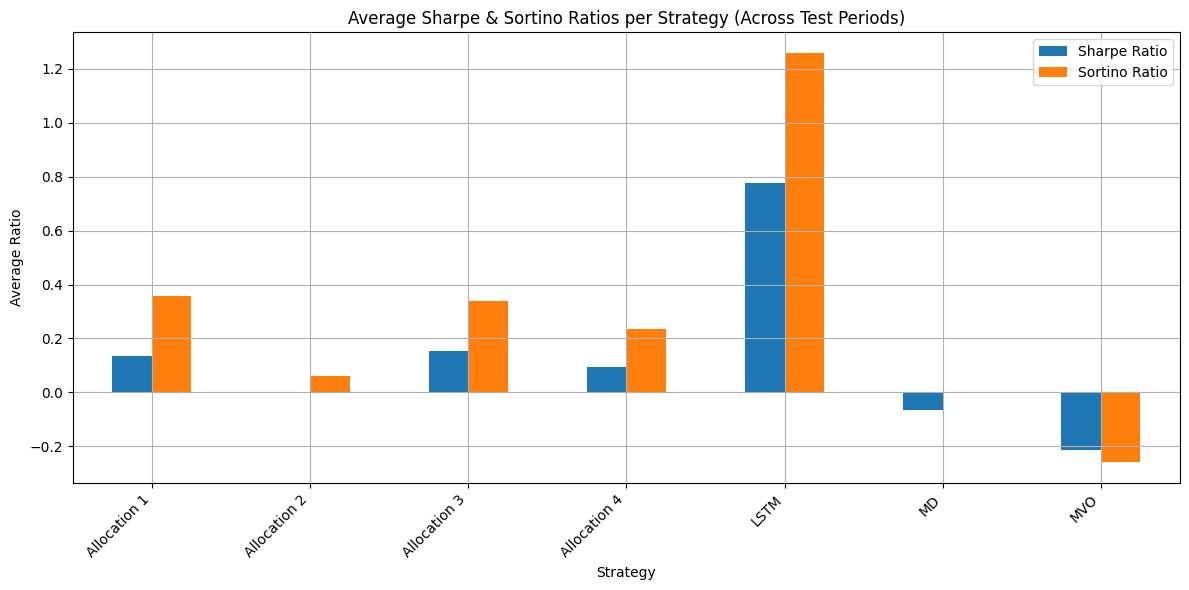

In [ ]:
# --- Plotting Suggestions (This part should remain the same as the previous suggestion) ---

# Plotting Sharpe and Sortino
# Strategies are the index, so we select metric columns and plot directly.
average_metrics_T[['Sharpe Ratio', 'Sortino Ratio']].plot(
    kind='bar',
    figsize=(12, 6),
    title='Average Sharpe & Sortino Ratios per Strategy (Across Test Periods)',
    grid=True,
    ylabel='Average Ratio'
)
plt.xlabel('Strategy') # Explicitly set x-axis label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

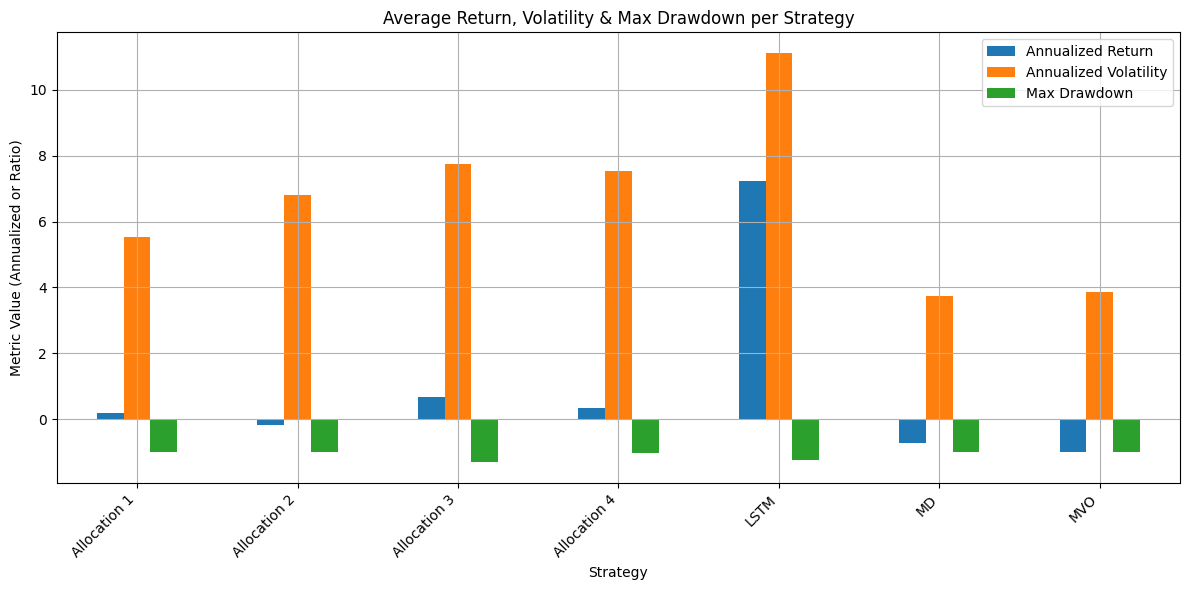

In [ ]:
# Plotting Return, Volatility, Max Drawdown
average_metrics_T[['Annualized Return', 'Annualized Volatility', 'Max Drawdown']].plot(
    kind='bar',
    figsize=(12, 6),
    title='Average Return, Volatility & Max Drawdown per Strategy',
    grid=True,
    ylabel='Metric Value (Annualized or Ratio)',
    # secondary_y=['Max Drawdown'] # Adjust secondary axis if needed
)
plt.xlabel('Strategy') # Explicitly set x-axis label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()